# DRILL: Mo' blobs, mo' problems?

You've seen how these three methods work on three blobs of reasonably separated data. Now go back and change the data. Create more or fewer blobs, and set the blobs closer together or farther apart. Set up at least **three different blob configurations**, then run the **four methods** ($k$-means, mean shift, spectral clustering and affinity propagation) on each one.  **Write up a report** for your mentor where you discuss what you learned about the clustering methods based on their relative performance for your different blob setups. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.cluster import MeanShift, estimate_bandwidth, SpectralClustering
from sklearn.cluster import AffinityPropagation, KMeans
from sklearn import metrics

In [3]:
prms = [{'n_samples':10000, 'n_features':4 - i, 'centers':i + 2, 'random_state':11} for i in range(3)]
data = [make_blobs(**prm) for prm in prms]

In [24]:
prms[2]

{'n_samples': 10000, 'n_features': 2, 'centers': 4, 'random_state': 11}

#### Group 0

{'n_samples': 10000, 'n_features': 4, 'centers': 2, 'random_state': 11}

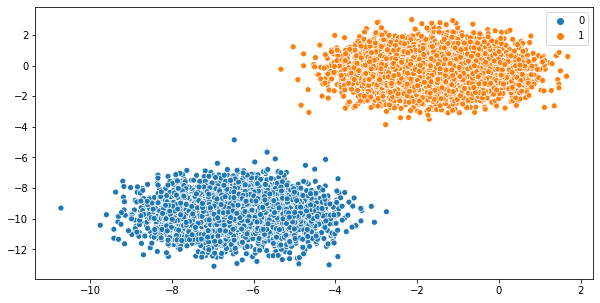

In [4]:
X0, y0 = data[0]
f, ax = plt.subplots(figsize=(10,5))
sns.scatterplot(X0[:, 0], X0[:, 1], hue=y0, ax=ax)
plt.show()

In [5]:
run = 0; num = 2
X_trn, X_tst, y_trn, y_tst = train_test_split( X0, y0, test_size=0.9, random_state=42)

bwh = estimate_bandwidth(X_trn)
clu_mst = MeanShift(bandwidth=bwh, bin_seeding=True)
clu_kmn = KMeans(n_clusters=num, random_state=42)
clu_apn = AffinityPropagation()
clu_scg = SpectralClustering(n_clusters=num)

labels = ['kmn', 'apn', 'mst', 'scg']
clus = [eval('clu_' + lab) for lab in labels]


rs0 = dict.fromkeys(labels)
for (i,clu) in enumerate(clus):
    t = %timeit -o  clu.fit(X_trn)
    prd = clu.fit(X_trn)
    
    rs0[labels[i]] = {'y_prd':prd, 'time':t}

9.17 ms ± 81 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.02 s ± 50.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
132 ms ± 3.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
112 ms ± 8.41 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [15]:
scores = []
for lab in labels:
    ct = pd.crosstab(rs0[lab]['y_prd'], y_trn)
    rs0[lab]['score'] = np.where(ct[0] >= ct[1],ct[0], ct[1] ).sum() / ct.sum().sum()
    scores.append(rs0[lab]['score'])
scores

[1.0, 1.0, 1.0, 1.0]

#### Group 1

{'n_samples': 10000, 'n_features': 3, 'centers': 3, 'random_state': 11}

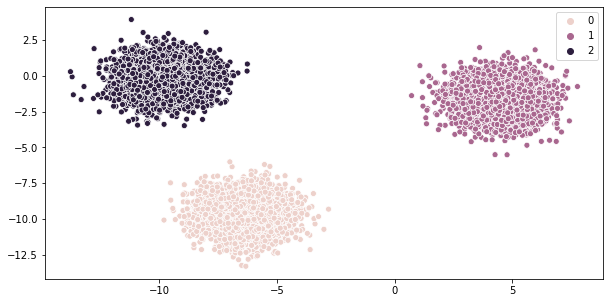

In [18]:
X1, y1 = data[1]
f, ax = plt.subplots(figsize=(10,5))
sns.scatterplot(X1[:, 0], X1[:, 1], hue=y1, ax=ax)
plt.show()

In [26]:
run = 1; num = 3
X_trn, X_tst, y_trn, y_tst = train_test_split( X1, y1, test_size=0.9, random_state=42)

bwh = estimate_bandwidth(X_trn)
clu_mst = MeanShift(bandwidth=bwh, bin_seeding=True)
clu_kmn = KMeans(n_clusters=num, random_state=42)
clu_apn = AffinityPropagation()
clu_scg = SpectralClustering(n_clusters=num)

labels = ['kmn', 'apn', 'mst', 'scg']
clus = [eval('clu_' + lab) for lab in labels]


rs1 = dict.fromkeys(labels)
for (i,clu) in enumerate(clus):
    t = %timeit -o  clu.fit(X_trn)
    prd = clu.fit(X_trn)
    
    rs1[labels[i]] = {'y_prd':prd, 'time':t}

11.9 ms ± 248 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.08 s ± 48 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
56.6 ms ± 328 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
128 ms ± 7.23 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
scores = []
for lab in labels:
    ct = pd.crosstab(rs1[lab]['y_prd'], y_trn)
    rs1[lab]['score'] = np.where(ct[1] >= ct[1],ct[1], ct[1] ).sum() / ct.sum().sum()
    scores.append(rs1[lab]['score'])
scores

#### Group 2
{'n_samples': 10000, 'n_features': 2, 'centers': 4, 'random_state': 11}

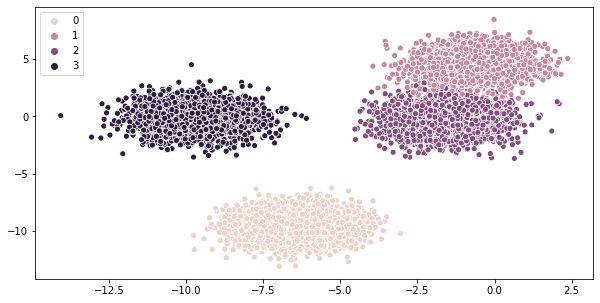

In [25]:
X2, y2 = data[2]
f, ax = plt.subplots(figsize=(10,5))
sns.scatterplot(X2[:, 0], X2[:, 1], hue=y2, ax=ax)
plt.show()

In [27]:
run = 2; num = 4
X_trn, X_tst, y_trn, y_tst = train_test_split( X2, y2, test_size=0.9, random_state=42)

bwh = estimate_bandwidth(X_trn)
clu_mst = MeanShift(bandwidth=bwh, bin_seeding=True)
clu_kmn = KMeans(n_clusters=num, random_state=42)
clu_apn = AffinityPropagation()
clu_scg = SpectralClustering(n_clusters=num)

labels = ['kmn', 'apn', 'mst', 'scg']
clus = [eval('clu_' + lab) for lab in labels]

rs2 = dict.fromkeys(labels)
for (i,clu) in enumerate(clus):
    t = %timeit -o  clu.fit(X_trn)
    prd = clu.fit(X_trn)
    rs2[labels[i]] = {'y_prd':prd, 'time':t}

15.8 ms ± 414 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.48 s ± 1.47 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
45.5 ms ± 623 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
211 ms ± 5.66 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
scores = []
for lab in labels:
    ct = pd.crosstab(rs1[lab]['y_prd'], y_trn)
    rs1[lab]['score'] = np.where(ct[1] >= ct[1],ct[1], ct[1] ).sum() / ct.sum().sum()
    scores.append(rs1[lab]['score'])
scores